# Detecção e Remoção de Outliers Univariados: Um Exemplo Prático 

### Contexto da Análise:
Um produtor de tomates estipulou sua meta de faturamento no valor de RS 3 Milhões para o segundo trimestre de 2023. Com isso, sua estratégia é aumentar o número de clientes e ele precisa saber qual o aumento necessário para alcançar sua meta.

Para encontrar esse percentual precisamos saber qual seria o número médio de tomates que seus clientes compram. Além disso, existem clientes que compram para consumo próprio, clientes que compram para revenda (Supermercados) e restaurantes. 

Porém, o produtor acredita que a maioria dos seus clientes são restaurantes (não existe uma classificação no banco de dados), mas mesmo assim sabe-se que existem grandes mercados parceiros que apresentam uma disparidade muito grande em relação aos outros clientes. Essas grandes redes classificaremos como Outliers e que podem atrapalhar nossa análise causando viés na média.

Para isso, tendo disponível a base de vendas do primeiro trimestre de 2023, precisaremos entender o cenário atual das vendas do produtor de tomate: quantas vendas realizou, quantos clientes, análise diária, etc.

### O que são outliers?

Outliers são valores muito distantes da média, podendo ser muito superior ou muito inferior. Com a presença de outliers o cálculo da média pode resultar em um valor viesado, pois valores muito discrepantes em relação às outras observações podem puxar o resultado tanto pra mais quanto pra menos. Para isso, precisamos detectar a presença dessas observações e removê-las para que a média tenha um resultado mais robusto.

Infelizmente, não existe uma regra para detectar definitivamente outliers. A detecção depende do contexto e do processo de coleta de dados. Embora não haja uma definição matemática única, existem procedimentos e testes estatísticos que podem ser utilizados para detectar esses pontos. Se os seus dados apresentam ou não distribuição normal, se são outliers univariados ou multivariados definirá qual método é mais adequado para sua análise.

Neste caso, nossos dados não apresentam distribuição normal e são outliers univariados (estamos lidando com apenas uma variável), então usaremos o método do Intervalo Interquartil (Boxplot).

O que causa a presença de outliers: Erros de medida, na extração dos dados, no processamento de dados, na amostragem e os naturais. Neste caso são outliers naturais, pois são apenas os clientes que apresentam um padrão diferente do restante da amostra.


### Sobre os Dados:
A base possui 44.236 linhas com o número de unidades compradas diariamente por cada cliente, ou seja, está agrupada por data e por cliente_id. Além disso, possui o valor diário referente ao primeiro trimestre de 2023.
Disponível em: https://www.kaggle.com/datasets/marianacaetano/compras-diarias-de-clientes

## 1. Análise Exploratória de Dados:

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from scipy import stats

In [347]:
compras_clientes = pd.read_csv('compras_clientes.csv', sep=';')
compras_clientes

,data,cliente_id,unid
0,10/01/2023,483014,3415
1,06/01/2023,483014,2968
2,05/01/2023,483014,2845
3,12/01/2023,483014,2798
4,03/01/2023,483014,2762
...,...,...,...
44231,31/03/2023,514069,1
44232,31/03/2023,316771,1
44233,02/02/2023,220693,1
44234,23/03/2023,471595,1


In [348]:
compras_clientes.dtypes

data          object
cliente_id     int64
unid           int64
dtype: object

In [349]:
# Observar valores ausentes
compras_clientes.isnull().sum()

data          0
cliente_id    0
unid          0
dtype: int64

In [350]:
# Transformação data em datetime
compras_clientes['data'] = pd.to_datetime(compras_clientes['data'], format='%d/%m/%Y')

# Criando coluna de valores (considerando que 3 tomates (aproximadamente 1kg) custa R$ 6,50)
compras_clientes['valor'] = (compras_clientes['unid']/3)*6.5

compras_clientes

,data,cliente_id,unid,valor
0,2023-01-10,483014,3415,7399.166667
1,2023-01-06,483014,2968,6430.666667
2,2023-01-05,483014,2845,6164.166667
3,2023-01-12,483014,2798,6062.333333
4,2023-01-03,483014,2762,5984.333333
...,...,...,...,...
44231,2023-03-31,514069,1,2.166667
44232,2023-03-31,316771,1,2.166667
44233,2023-02-02,220693,1,2.166667
44234,2023-03-23,471595,1,2.166667


### 1.1 Análise das Vendas

#### Visão Geral

In [396]:
total_tomates = compras_clientes['unid'].sum()
valor_total = round(compras_clientes['valor'].sum(),2)

print('Total de tomates vendido em unidades (T1/2023):', total_tomates)
print('Total de tomates vendido em reais (T1/2023): R$', valor_total)

Total de tomates vendido em unidades (T1/2023): 1045144
Total de tomates vendido em reais (T1/2023): R$ 2264478.67


In [352]:
compras_clientes['unid'].describe()

count    44236.000000
mean        23.626549
std         89.571554
min          1.000000
25%          1.000000
50%          3.000000
75%         13.000000
max       3415.000000
Name: unid, dtype: float64

In [353]:
compras_clientes['valor'].describe()

count    44236.000000
mean        51.190855
std        194.071700
min          2.166667
25%          2.166667
50%          6.500000
75%         28.166667
max       7399.166667
Name: valor, dtype: float64

#### Vendas Diárias

In [354]:
# Soma agrupando por data
vendas_diarias = pd.DataFrame(compras_clientes.groupby(['data']).aggregate({'unid':'sum','valor':'sum'}))
vendas_diarias

,unid,valor
data,,
2023-01-01,4804,10408.666667
2023-01-02,10755,23302.500000
2023-01-03,13952,30229.333333
2023-01-04,13044,28262.000000
2023-01-05,14634,31707.000000
...,...,...
2023-03-27,8538,18499.000000
2023-03-28,9732,21086.000000
2023-03-29,7640,16553.333333


In [355]:
vendas_diarias.reset_index(inplace=True)
vendas_diarias = vendas_diarias.rename(columns = {'index':'data'}) # Removendo data do index

vendas_diarias = vendas_diarias.sort_values(by='data') # Ordenando por data

vendas_diarias

,data,unid,valor
0,2023-01-01,4804,10408.666667
1,2023-01-02,10755,23302.500000
2,2023-01-03,13952,30229.333333
3,2023-01-04,13044,28262.000000
4,2023-01-05,14634,31707.000000
...,...,...,...
85,2023-03-27,8538,18499.000000
86,2023-03-28,9732,21086.000000
87,2023-03-29,7640,16553.333333
88,2023-03-30,7994,17320.333333


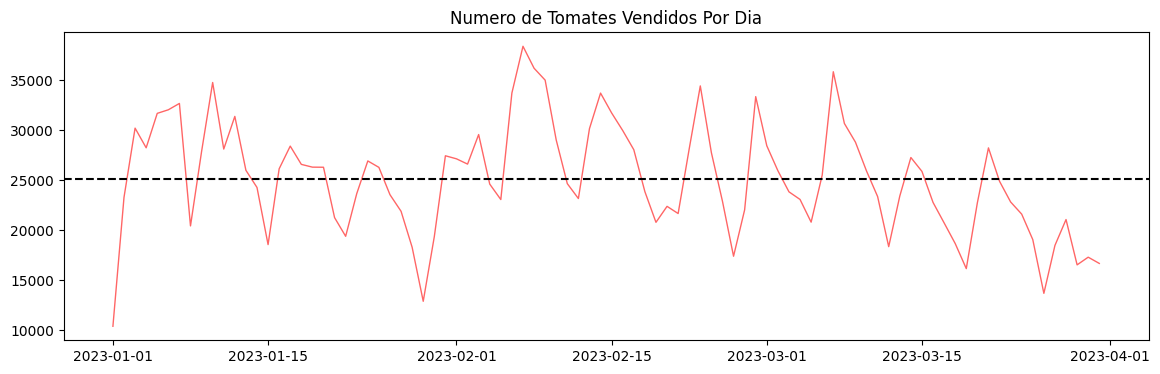

In [357]:
# Visualizando as vendas diárias
fig, ax = plt.subplots(1,1, figsize=(14, 4))

ax.plot(vendas_diarias['data'], vendas_diarias['valor'],color='red', alpha=0.6, linewidth=1)
plt.xlabel("")  
plt.ylabel("")
plt.title("Numero de Tomates Vendidos Por Dia")

media = vendas_diarias['valor'].mean()
ax.axhline(media, color = 'k', linestyle='--')
# ax.annotate('média', xy=(, media),fontsize=50)

plt.show()

In [392]:
print('Média Diária de Vendas (Unid.):', ceil(vendas_diarias['unid'].mean()))
print('Média Diária de Vendas (R$):', round((vendas_diarias['valor'].mean()/3)*6.5,2))

Média Diária de Vendas (Unid.): 11613
Média Diária de Vendas (R$): 54515.23


#### Vendas Mensais

In [307]:
# Criar coluna de mês
compras_clientes['mes'] = compras_clientes['data'].dt.strftime('%m-%Y')

In [308]:
# Soma agrupando por mês
vendas_diarias = pd.DataFrame(compras_clientes.groupby(['mes']).aggregate({'unid':'sum','valor':'sum'}))
vendas_mensal

,unid,valor
mes,,
01-2023,357794,775220.333333
02-2023,360029,780062.833333
03-2023,327321,709195.500000


<Axes: xlabel='mes'>

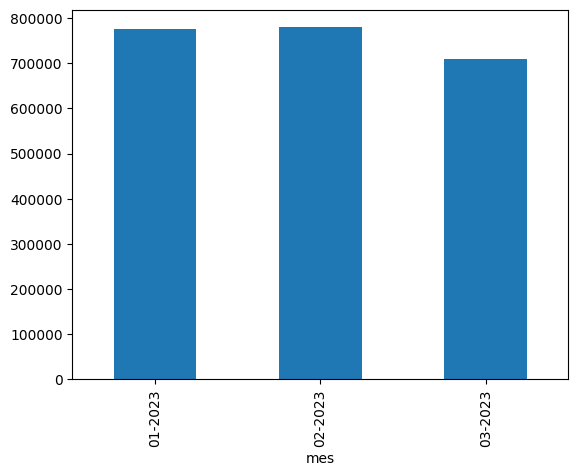

In [358]:
vendas_mensal['valor'].transpose().plot.bar()


In [393]:
print('Média de Vendas (Unid.):', ceil(vendas_mensal['unid'].mean()))
print('Média de Vendas (R$):', round(vendas_mensal['valor'].mean(),0))

Média de Vendas (Unid.): 348382
Média de Vendas (R$): 754826.0


In [311]:
unid_jan  = vendas_mensal['unid'].loc['01-2023']
unid_fev  = vendas_mensal['unid'].loc['02-2023']
unid_mar  = vendas_mensal['unid'].loc['03-2023']

valor_jan = vendas_mensal['valor'].loc['01-2023']
valor_fev = vendas_mensal['valor'].loc['02-2023']
valor_mar = vendas_mensal['valor'].loc['03-2023']

In [312]:
print('Variação Mensal Jan-Fev (Unid.):', round((unid_fev-unid_jan)/unid_jan*100,2), '%')
print('Variação Mensal Fev-Mar (Unid.):', round((unid_mar-unid_fev)/unid_fev*100,2), '%')

print('Variação Mensal Jan-Fev (R$):', round((valor_fev-valor_jan)/valor_jan*100,2), '%')
print('Variação Mensal Fev-Mar (R$):', round((valor_mar-valor_fev)/valor_fev*100,2), '%')

Variação Mensal Jan-Fev (Unid.): 0.62 %
Variação Mensal Fev-Mar (Unid.): -9.08 %
Variação Mensal Jan-Fev (R$): 0.62 %
Variação Mensal Fev-Mar (R$): -9.08 %


In [313]:
print('Variação Média Mensal (Unid.):', round((unid_mar/unid_jan)**(1/3)-1,2), '%')
print('Variação Média Mensal (R$):', round((valor_mar/valor_jan)**(1/3)-1,2), '%')

Variação Média Mensal (Unid.): -0.03 %
Variação Média Mensal (R$): -0.03 %


### 1.2 Análise dos Clientes

#### Número de Clientes

In [398]:
total_clientes = compras_clientes['cliente_id'].nunique()

print('Número de Clientes:', total_clientes)

Número de Clientes: 1630


In [315]:
clientes_por_dia = pd.DataFrame(compras_clientes.groupby(['data'])['cliente_id'].nunique())
clientes_por_dia = clientes_por_dia.rename(columns={'cliente_id': 'clientes'})
clientes_por_dia

,clientes
data,
2023-01-01,325
2023-01-02,453
2023-01-03,522
2023-01-04,527
2023-01-05,553
...,...
2023-03-27,462
2023-03-28,498
2023-03-29,454


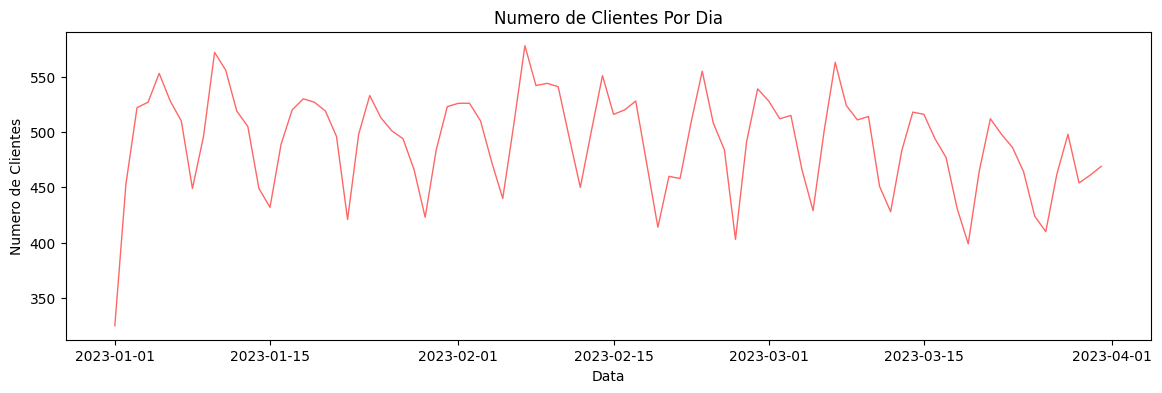

In [316]:
# Visualizando o número de clientes por dia
fig, ax = plt.subplots(1,1, figsize=(14, 4))

ax.plot(clientes_por_dia.index, clientes_por_dia['clientes'],color='red', alpha=0.6, linewidth=1)
plt.xlabel("Data")  
plt.ylabel("Numero de Clientes")
plt.title("Numero de Clientes Por Dia")

plt.show()

In [317]:
print('Média Diária de Clientes:', round(clientes_por_dia['clientes'].mean(),0))

Média Diária de Clientes: 492.0


In [318]:
clientes_mensal = pd.DataFrame(compras_clientes.groupby(['mes'])['cliente_id'].nunique())
clientes_mensal = clientes_mensal.rename(columns={'cliente_id': 'clientes'})
clientes_mensal

,clientes
mes,
01-2023,1255
02-2023,1197
03-2023,1244


<Axes: xlabel='mes'>

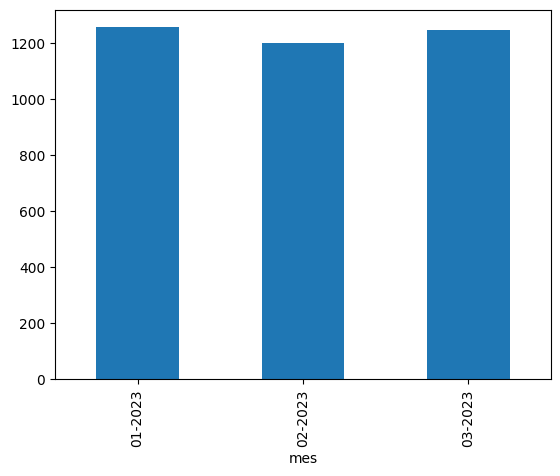

In [319]:
clientes_mensal['clientes'].transpose().plot.bar()

In [320]:
print('Média Mensal de Clientes:', round(clientes_mensal['clientes'].mean(),0))

Média Mensal de Clientes: 1232.0


In [321]:
clientes_jan  = clientes_mensal['clientes'].loc['01-2023']
clientes_fev  = clientes_mensal['clientes'].loc['02-2023']
clientes_mar  = clientes_mensal['clientes'].loc['03-2023']

In [322]:
print('Variação Mensal Jan-Fev:', round((clientes_fev-clientes_jan)/clientes_jan*100,2), '%')
print('Variação Mensal Fev-Mar:', round((clientes_mar-clientes_fev)/clientes_fev*100,2), '%')
print('Variação Média Mensal:', round((clientes_mar/clientes_jan)**(1/3)-1,2), '%')

Variação Mensal Jan-Fev: -4.62 %
Variação Mensal Fev-Mar: 3.93 %
Variação Média Mensal: -0.0 %


#### Vendas por Cliente

In [367]:
vendas_cliente = pd.DataFrame(compras_clientes.groupby(['cliente_id']).aggregate({'unid':'sum','valor':'sum'}))
vendas_cliente

,unid,valor
cliente_id,,
156,13,28.166667
364,66,143.000000
416,841,1822.166667
1872,27,58.500000
4212,39,84.500000
...,...,...
987601,9,19.500000
987620,1,2.166667
992056,2,4.333333


In [391]:
# média com outliers
media_com_outliers = ceil(vendas_cliente['unid'].mean())
print('Média de Tomates Vendidos por Cliente (Unid.):', ceil(vendas_cliente['unid'].mean()))
print('Média de Tomates Vendidos por Cliente (R$):', round(vendas_cliente['valor'].mean(),2))

Média de Tomates Vendidos por Cliente (Unid.): 642
Média de Tomates Vendidos por Cliente (R$): 1389.25


### 1.3 Distribuição e Detecção de Outliers

Text(0.5, 1.0, 'Boxplot do Número de Compras')

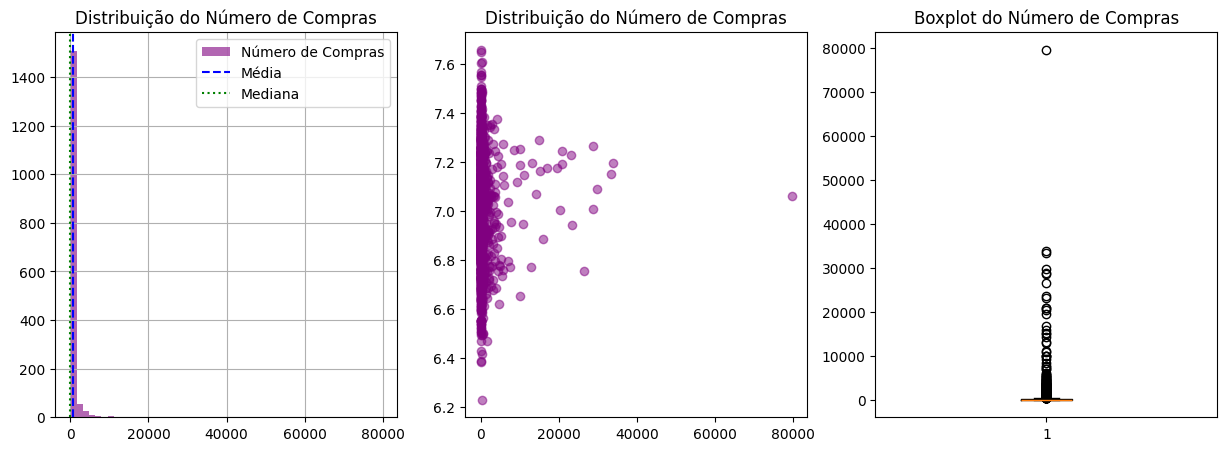

In [325]:
vendas_cliente = vendas_cliente['unid']

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
vendas_cliente.hist(bins=50, label='Número de Compras', alpha=0.6, color = 'purple')
plt.axvline(np.mean(vendas_cliente), ls='--', c='b', label="Média")
plt.axvline(np.median(vendas_cliente), ls=':', c='g', label="Mediana")
plt.ylabel("")
plt.title("Distribuição do Número de Compras")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(vendas_cliente, np.random.normal(7, 0.2, size=vendas_cliente.shape[0]), alpha=0.5, color = 'purple')
plt.ylabel("")
plt.title("Distribuição do Número de Compras")

plt.subplot(1, 3, 3)
plt.boxplot(vendas_cliente)
plt.ylabel("")
plt.title("Boxplot do Número de Compras")

De acordo com os gráficos, percebemos que há muitas observações bastante discrepante em relação às demais. Com isso, nota-se a presença de outliers. Mas para encontrar o melhor método, precisamos verificar a normalidade dos dados. Lembrando que esses outliers são univariados, ou seja, são pontos extremos de uma só variável, que nesse caso foi a de 'Número de Compras'.

#### Teste de Normalidade

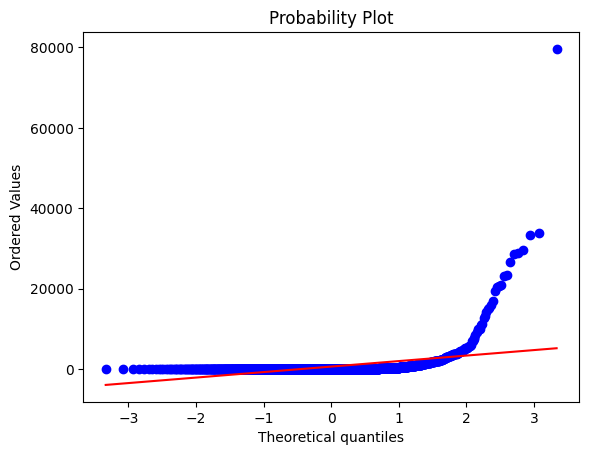

In [326]:
stats.probplot(vendas_cliente, dist="norm", plot=plt)
plt.show()

In [327]:
# H0: Apresenta distribuição normal
# H1: Não apresenta distribuição normal
k2, p = stats.normaltest(vendas_cliente)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha: 
    print("Rejeita a hipótese nula")
else:
    print("Não rejeita a hipótese nula")

p = 0
Rejeita a hipótese nula


Com base nas análises gráficas e no teste estatístico podemos identificar a não normalidade dos dados, portanto, a melhor forma de fazer a limpeza desses dados é utilizando o método do boxplot.

## 2. Remoção de Outliers Utilizando Boxplot

O boxplot é uma ferramento utilizada para observar a distribuição dos dados, podendo então fazer detecção de outliers e até comparação entre diferentes amostras. Dentro desse diagrama de caixa conseguimos visualizar algumas medidas de estatística descritiva como o mínimo, máximo, primeiro quartil, segundo quartil ou mediana e o terceiro quartil.

Lembrando que o percentil é uma medida de posição que, dada uma amostra ordenada em ordem crescente e dividida em 100 partes, indica o valor do qual determinado percentual de elementos da amostra são menores ou iguais a ele. Os quartis nada mais são que os percentis 25, 50 e 75, representando respectivamente o primeiro, segundo e terceiro quartil. Além disso, o percentil 50 ou segundo quartil equivalem à mediana.

![Logo do R](https://www.alura.com.br/artigos/assets/boxplot/imagem-2.png)

#### 2.1 Calculando os Quartis

In [369]:
Q1 = np.percentile(vendas_cliente, 25) # 25º percentil
Q3 = np.percentile(vendas_cliente, 75) # 75º percentil

print('Primeiro Quartil (Q1):', Q1)
print('Terceiro Quartil (Q3):', Q3)

Primeiro Quartil (Q1): 6.5
Terceiro Quartil (Q3): 218.20833333333331


#### 2.2 Calculando dos Limites

In [329]:
C   = 1.5 # Constante
AIQ = Q3 - Q1 # Amplitude Interquartil ou Intervalo interquartil
LI  = Q1 - C*AIQ # Limite Inferior
LS  = Q3 + C*AIQ # Limite Superior

print('IIQ:', AIQ)
print('Limite Inferior:', LI)
print('Limite Superior:', LS)

IIQ: 145.0
Limite Inferior: -213.5
Limite Superior: 366.5


#### 2.3 Definindo Outliers
Identificando os outliers, que são os valores que estão entre o limite inferior e o limite superior.

In [330]:
sem_outliers = []
outliers = []
for t in vendas_cliente:
    if t > LS or t < LI:
        outliers.append(t)
    else:
        sem_outliers.append(t)

In [331]:
print(f'Outliers: {len(outliers)} ({round(len(outliers)/(len(vendas_cliente))*100,2)}%)')
print(f'Não Outliers: {len(sem_outliers)} ({round(len(sem_outliers)/(len(vendas_cliente))*100,2)}%)')

Outliers: 267 (16.38%)
Não Outliers: 1363 (83.62%)


#### 2.4 Selecionando e Analisando o Resultado das Amostras

##### Amostra Sem Outliers

In [332]:
compras_sem_outliers = pd.DataFrame(data=sem_outliers, columns=['compras'])
compras_sem_outliers.head()

,compras
0,13
1,66
2,27
3,39
4,1


In [375]:
print('Média de Tomates Vendidos por Cliente (Unid):', round(compras_sem_outliers['compras'].mean(),0))
print('Média de Tomates Vendidos por Cliente (R$):', round(round(compras_sem_outliers['compras'].mean(),0)/3*6.5,2))

Média de Tomates Vendidos por Cliente (Unid): 47.0
Média de Tomates Vendidos por Cliente (R$): 101.83


Text(0.5, 1.0, 'Boxplot do Número de Compras Diárias')

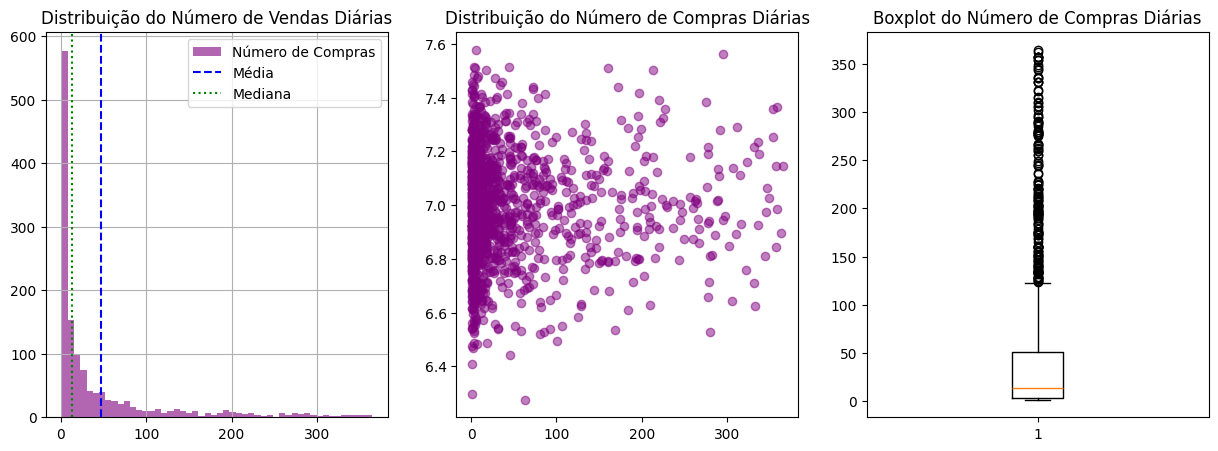

In [334]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
compras_sem_outliers['compras'].hist(bins=50, label='Número de Compras', alpha=0.6, color = 'purple')
plt.axvline(np.mean(compras_sem_outliers['compras']), ls='--', c='b', label="Média")
plt.axvline(np.median(compras_sem_outliers['compras']), ls=':', c='g', label="Mediana")
plt.ylabel("")
plt.title("Distribuição do Número de Vendas Diárias")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(compras_sem_outliers['compras'], np.random.normal(7, 0.2, size=compras_sem_outliers.shape[0]), alpha=0.5, color = 'purple')
plt.ylabel("")
plt.title("Distribuição do Número de Compras Diárias")

plt.subplot(1, 3, 3)
plt.boxplot(compras_sem_outliers)
plt.ylabel("")
plt.title("Boxplot do Número de Compras Diárias")

Mesmo retirando grande parte dos outliers, segundo o boxplot, percebe-se que ainda existe a presença de observações superiores dentro da amostra. Porém, é possível realizar a análise da média depois dessa limpeza.

##### Amostra de Outliers

In [379]:
compras_outliers = pd.DataFrame(data=outliers, columns=['compras'])
compras_outliers.head()

,compras
0,841
1,1498
2,462
3,3194
4,543


In [380]:
# média outliers
print('Média de Tomates Vendidos por Cliente (Unid):', round(compras_outliers['compras'].mean(),0))
print('Média de Tomates Vendidos por Cliente (R$):', round(round(compras_outliers['compras'].mean(),0)/3*6.5,2))

Média de Tomates Vendidos por Cliente (Unid): 3676.0
Média de Tomates Vendidos por Cliente (R$): 7964.67


Text(0.5, 1.0, 'Boxplot do Número de Compras Diárias')

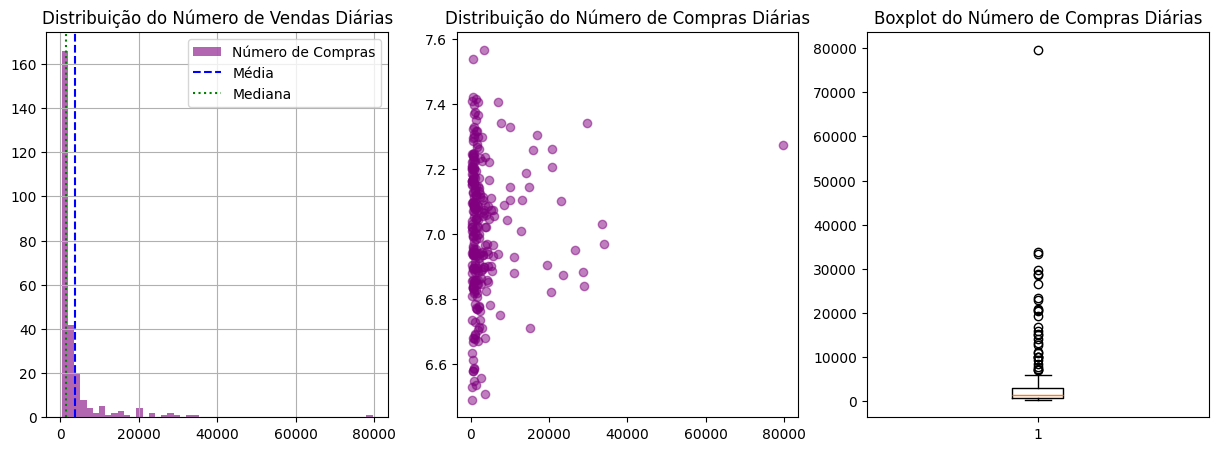

In [381]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
compras_outliers['compras'].hist(bins=50, label='Número de Compras', alpha=0.6, color = 'purple')
plt.axvline(np.mean(compras_outliers['compras']), ls='--', c='b', label="Média")
plt.axvline(np.median(compras_outliers['compras']), ls=':', c='g', label="Mediana")
plt.ylabel("")
plt.title("Distribuição do Número de Vendas Diárias")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(compras_outliers['compras'], np.random.normal(7, 0.2, size=compras_outliers.shape[0]), alpha=0.5, color = 'purple')
plt.ylabel("")
plt.title("Distribuição do Número de Compras Diárias")

plt.subplot(1, 3, 3)
plt.boxplot(compras_outliers)
plt.ylabel("")
plt.title("Boxplot do Número de Compras Diárias")

## 3. Proposta de Solução do Problema
***

Com base na análise da amostra com outliers, no último trimestre um cliente comprou, em média, 642 tomates (RS 1389,25). Fazendo a mesma análise na amostra sem outliers esse valor caiu para 47 (RS 101.83), ou seja, a grande maioria dos clientes do produtor de tomate compraram, uma média de 47 tomates dentro do período do último trimestre. Porém, se considerarmos apenas a conversão de clientes pequenos, o esforço pela aquisição desses novos clientes seria muito grande para pouco retorno.

In [411]:
novos_clientes = ceil((3000000 - 2264478.67)/101.83)

print('Número de Conversões de Clientes Pequenos:', novos_clientes)
print('Crescimento de Clientes Esperado:', round(((novos_clientes+total_clientes)-total_clientes)/total_clientes*100,1), '%')

Número de Conversões de Clientes Pequenos: 7224
Crescimento de Clientes Esperado: 443.2 %


Com 1.630 clientes, o produtor consegue faturar RS 2.264.478,67. Levando em consideração apenas a aquisição de novos clientes com o mesmo perfil do cliente médio, para alcançar a meta de RS 3 Milhões, precisaremos de 7.224 novos clientes, um aumento de 343,2%. Muito esforço para um retorno tão pequeno. Portanto, seria mais rentável a aquisição de novos grandes clientes como os restaurantes e mercados. Com isso, faz-se necessário a previsão do retorno da conversão de grandes clientes (outliers). Lembrando que, em média, um novo comprador outlier compra 3676 tomates, um retorno de RS 7964.67 por clientes.

In [412]:
novos_clientes_outliers = ceil((3000000 - 2264478.67)/7964.67)

print('Número de Conversões de Clientes Grandes:', novos_clientes_outliers)
print('Crescimento de Clientes Esperado:', round(((novos_clientes_outliers+total_clientes)-total_clientes)/total_clientes*100,1), '%')

Número de Conversões de Clientes Grandes: 93
Crescimento de Clientes Esperado: 5.7 %


Para alcançar a meta de RS 3 Milhões é necessário o aumento de 443% clientes pequenos ou 6% de grandes clientes. Como não é possível medir o esforço para a conversão de cada tipo de clientes, o melhor cenário seria a identificação dos clientes por tamanho, exemplo: cosumidores, restaurantes, supermercado e mercearias. A classificação dos cliente nos ajudaria a entender o comportamento e as análises seriam mais robustas.

Para que haja essa classificação, o produtor poderá coletar manualmente com cada um de seus clientes ou definir um método criando uma regra de negócio. Por exemplo: clintes com X compras por dia são identificados como Y.